# Environment setup

In [383]:
import mindspore
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV

In [384]:
from mindspore.common import dtype as mstype
from mindspore.common.initializer import Normal

In [385]:
import mindspore.nn as nn
from mindspore.nn.metrics import Accuracy, Loss

In [386]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor, Callback

In [387]:
from mindspore import Model
from mindspore import save_checkpoint, load_checkpoint
from mindspore import context

In [388]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os, stat

In [389]:
# Configure the MindSpore environment
device_target = context.get_context('device_target')
dataset_sink_mode = True if device_target in ['Ascend', 'GPU'] else False

In [390]:
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)

In [415]:
# print(f'device_target: {device_target}')
# print(f'dataset_sink_mode: {dataset_sink_mode}')

device_target: CPU
dataset_sink_mode: False


# Data display

In [392]:
train_path = os.path.join('data', '10-batches-bin')  # Path of the training set
test_path = os.path.join('data', '10-verify-bin')  # Path of the test set

In [393]:
print(f' Path of the training set :{train_path}')
print(f' Path of the test set :{test_path}')

 Path of the training set :data/10-batches-bin
 Path of the test set :data/10-verify-bin


In [394]:
# Create an image label list.
category_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
                 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [395]:
demo_data = ds.Cifar10Dataset(test_path)

In [396]:
plt.figure(figsize=(6, 6))

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

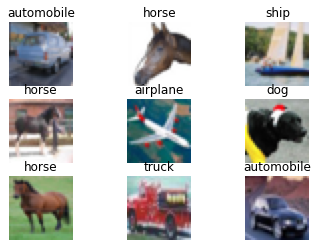

In [397]:
subgraph_counter = 1

for dic in demo_data.create_dict_iterator():
    plt.subplot(3, 3, subgraph_counter)
    plt.imshow(dic['image'].asnumpy())
    plt.axis('off')
    plt.title(category_dict[dic['label'].asnumpy().item()])
    subgraph_counter += 1

    if subgraph_counter > 9:
        break
plt.show()

# Data Processing

In [398]:
# avg value and std of the dataset for normalization
ds_train = ds.Cifar10Dataset(train_path)
tmp = np.asarray([x['image'] for x in ds_train.create_dict_iterator(output_numpy=True)])

RGB_mean = tuple(np.mean(tmp, axis=(0, 1, 2)))
RGB_std = tuple(np.std(tmp, axis=(0, 1, 2)))

print(RGB_mean)
print(RGB_std)

(125.306918046875, 122.950394140625, 113.86538318359375)
(62.993219277764794, 62.088707640429284, 66.70489964062186)


In [399]:
def create_dataset(data_path, batch_size=32, repeat_num=1, usage='train'):
    """
    Process data.
    Args:
    data_path (str): data path
    batch_size (int): batch size
    usage (str): training or test
    """
    data = ds.Cifar10Dataset(data_path)
    data = data.shuffle(buffer_size=10000)

    if usage == 'train':
        trans = [
            CV.Normalize(RGB_mean, RGB_std),
            CV.RandomCrop([32, 32], [4, 4, 4, 4]),
            CV.RandomHorizontalFlip(),
            CV.HWC2CHW()
        ]

    else:
        trans = [
            CV.Normalize(RGB_mean, RGB_std),
            CV.HWC2CHW()
        ]

    typecast_op = C.TypeCast(mstype.int32)

    data = data.map(input_columns='label', operations=typecast_op)
    data = data.map(input_columns='image', operations=trans)
    data = data.batch(batch_size, drop_remainder=True)
    data = data.repeat(repeat_num)

    return data

# Network -> LeNet5

In [400]:
class LeNet5(nn.Cell):
    """
        LeNet5
        Args:
        num_class (int): number of output classes
        num_channel (int): number of input channels
    """

    def __init__(self, num_class=10, num_channel=3):
        super(LeNet5, self).__init__()
        # Convolutional layer
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        # Fully connected layer
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        # Activation function
        self.relu = nn.ReLU()
        # Maximum pooling layer
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Flatten the network.
        self.flatten = nn.Flatten()

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Model Training

In [401]:
# train/test datasets

In [402]:
train_data = create_dataset(train_path, batch_size=32, usage='train')
test_data = create_dataset(test_path, batch_size=50, usage='test')

In [403]:
network1 = LeNet5(10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_opt = nn.Momentum(params=network1.trainable_params(), learning_rate=0.01, momentum=0.9)
model = Model(network=network1, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy':
                                                                                  Accuracy(), 'loss': Loss()})

In [404]:
# loss of each epoch
class TrainHistory(Callback):
    def __init__(self, history):
        super(TrainHistory, self).__init__()
        self.history = history

    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs.asnumpy()
        self.history.append(loss)

In [405]:
# loss and accuracy of the model in the test set -> save network params with the highest accuracy
class EvalHistory(Callback):
    best_param = None

    def __init__(self, model, loss_history, acc_history, eval_data):
        super(EvalHistory, self).__init__()

        self.loss_history = loss_history
        self.acc_history = acc_history
        self.eval_data = eval_data
        self.model = model

    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        res = self.model.eval(self.eval_data, dataset_sink_mode=False)
        if len(self.acc_history) == 0 or res['accuracy'] >= max(self.acc_history):
            self.best_param = copy.deepcopy(cb_params.network)

        self.loss_history.append(res['loss'])
        self.acc_history.append(res['accuracy'])

        print('acc_eval: ', res['accuracy'])

    def end(self, run_context):
        best_param_path = os.path.join(ckpt_path, 'best_param.ckpt')

        if os.path.exists(best_param_path):
            os.chmod(best_param_path, stat.S_IWRITE)

        save_checkpoint(self.best_param, best_param_path)



In [406]:
ckpt_path = os.path.join('.', 'results')
history = {'loss': [], 'loss_eval': [], 'acc_eval': []}
config_ck = CheckpointConfig(save_checkpoint_steps=2000,
                             keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix='checkpoint_lenet', directory=ckpt_path, config=config_ck)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
loss_cb = LossMonitor(per_print_times=500)
train_hist_cb = TrainHistory(history['loss'])
eval_hist_cb = EvalHistory(model=model,
                           loss_history=history['loss_eval'],
                           acc_history=history['acc_eval'],
                           eval_data=test_data)

epoch = 10
model.train(epoch, train_data, callbacks=[train_hist_cb, eval_hist_cb, time_cb, ckpoint_cb, loss_cb],
            dataset_sink_mode=dataset_sink_mode)

epoch: 1 step: 500, loss is 2.3155555725097656
epoch: 1 step: 1000, loss is 2.2588391304016113
epoch: 1 step: 1500, loss is 1.8971487283706665


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:07:19.239.404 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.2574
epoch time: 18549.500 ms, per step time: 11.875 ms
epoch: 2 step: 438, loss is 1.910379409790039
epoch: 2 step: 938, loss is 2.1224985122680664
epoch: 2 step: 1438, loss is 1.7721143960952759


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:07:35.851.449 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.43
epoch time: 16416.049 ms, per step time: 10.510 ms
epoch: 3 step: 376, loss is 1.6610506772994995
epoch: 3 step: 876, loss is 1.8168350458145142
epoch: 3 step: 1376, loss is 1.2916061878204346


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:07:52.851.041 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.4883
epoch time: 16999.606 ms, per step time: 10.883 ms
epoch: 4 step: 314, loss is 1.7786115407943726
epoch: 4 step: 814, loss is 1.2689839601516724
epoch: 4 step: 1314, loss is 1.3990705013275146


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:08:09.340.944 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.5322
epoch time: 16475.309 ms, per step time: 10.548 ms
epoch: 5 step: 252, loss is 1.2340177297592163
epoch: 5 step: 752, loss is 1.0823723077774048
epoch: 5 step: 1252, loss is 1.285935401916504


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:08:25.832.138 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.5278
epoch time: 16480.537 ms, per step time: 10.551 ms
epoch: 6 step: 190, loss is 1.0591384172439575
epoch: 6 step: 690, loss is 1.3965647220611572
epoch: 6 step: 1190, loss is 1.8131318092346191


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:08:43.960.057 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.5637
epoch time: 18215.571 ms, per step time: 11.662 ms
epoch: 7 step: 128, loss is 1.4579074382781982
epoch: 7 step: 628, loss is 1.3491411209106445
epoch: 7 step: 1128, loss is 1.0718430280685425


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:09:01.412.480 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.574
epoch time: 17615.566 ms, per step time: 11.278 ms
epoch: 8 step: 66, loss is 1.512157917022705
epoch: 8 step: 566, loss is 1.3397139310836792
epoch: 8 step: 1066, loss is 1.3305654525756836


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:09:18.958.163 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.5698
epoch time: 17368.302 ms, per step time: 11.119 ms
epoch: 9 step: 4, loss is 1.5125575065612793
epoch: 9 step: 504, loss is 1.6793901920318604
epoch: 9 step: 1004, loss is 1.7894974946975708
epoch: 9 step: 1504, loss is 1.3395062685012817


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:09:36.459.019 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.5753
epoch time: 17532.633 ms, per step time: 11.224 ms
epoch: 10 step: 442, loss is 1.6468698978424072
epoch: 10 step: 942, loss is 1.400078535079956
epoch: 10 step: 1442, loss is 1.3003871440887451


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:09:53.918.091 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.5871
epoch time: 17457.917 ms, per step time: 11.177 ms


# Model Evaluation

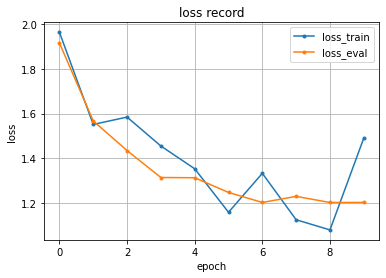

In [407]:
def plot_loss(hist):
    plt.plot(hist['loss'], marker='.')
    plt.plot(hist['loss_eval'], marker='.')
    plt.title('loss record')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss_train', 'loss_eval'], loc='upper right')
    plt.show()
    plt.close()


plot_loss(history)

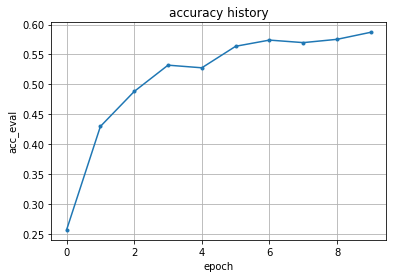

In [408]:
def plot_accuracy(hist):
    plt.plot(hist['acc_eval'], marker='.')
    plt.title('accuracy history')
    plt.xlabel('epoch')
    plt.ylabel('acc_eval')
    plt.grid()
    plt.show()
    plt.close()


plot_accuracy(history)

In [409]:
load_checkpoint(os.path.join(ckpt_path, 'best_param.ckpt'), net=network1)
res = model.eval(test_data, dataset_sink_mode=dataset_sink_mode)
print(res)

{'accuracy': 0.5871, 'loss': 1.2039801740646363}


# Model Optimization

In [416]:
class LeNet5_2(nn.Cell):
    def __init__(self, num_class=10, num_channel=3):
        super(LeNet5_2, self).__init__()

        self.conv1 = nn.Conv2d(num_channel, 32, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.conv2 = nn.Conv2d(32, 64, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.conv3 = nn.Conv2d(64, 128, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.fc1 = nn.Dense(128 * 2 * 2, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.num_class = num_class

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

In [417]:

train_data = create_dataset(train_path, batch_size=32, usage='train')
test_data = create_dataset(test_path, batch_size=50, usage='test')

In [418]:
network2 = LeNet5_2(10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_opt = nn.Adam(params=network2.trainable_params())
model = Model(network=network2, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy': Accuracy(), 'loss': Loss()})

In [419]:
hist = {'loss': [], 'loss_eval': [], 'acc_eval': []}
config_ck = CheckpointConfig(save_checkpoint_steps=2000, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix='checkpoint_lenet_2', directory=ckpt_path, config=config_ck)
train_hist_cb = TrainHistory(hist['loss'])
eval_hist_cb = EvalHistory(model=model,
                           loss_history=hist['loss_eval'],
                           acc_history=hist['acc_eval'],
                           eval_data=test_data)

# Retrain and Evaluation

In [420]:
epoch = 10
model.train(epoch, train_data,
            callbacks=[train_hist_cb, eval_hist_cb, time_cb, ckpoint_cb,
                       LossMonitor(per_print_times=500)],
            dataset_sink_mode=dataset_sink_mode)

epoch: 1 step: 500, loss is 1.780688762664795
epoch: 1 step: 1000, loss is 1.5111629962921143
epoch: 1 step: 1500, loss is 1.5785396099090576


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:14:57.428.172 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.4379
epoch time: 58725.602 ms, per step time: 37.596 ms
epoch: 2 step: 438, loss is 1.4492976665496826
epoch: 2 step: 938, loss is 1.319606065750122
epoch: 2 step: 1438, loss is 1.2623263597488403


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:15:56.631.430 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.5691
epoch time: 59262.902 ms, per step time: 37.940 ms
epoch: 3 step: 376, loss is 1.040252685546875
epoch: 3 step: 876, loss is 1.2006933689117432
epoch: 3 step: 1376, loss is 1.5086904764175415


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:16:51.630.217 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.6231
epoch time: 55957.848 ms, per step time: 35.824 ms
epoch: 4 step: 314, loss is 0.8377825617790222
epoch: 4 step: 814, loss is 1.06071138381958
epoch: 4 step: 1314, loss is 0.9757420420646667


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:17:48.708.819 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.6334
epoch time: 55470.840 ms, per step time: 35.513 ms
epoch: 5 step: 252, loss is 0.6138803362846375
epoch: 5 step: 752, loss is 1.2996063232421875
epoch: 5 step: 1252, loss is 1.1701196432113647


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:18:47.511.247 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.6889
epoch time: 58856.654 ms, per step time: 37.680 ms
epoch: 6 step: 190, loss is 0.880756139755249
epoch: 6 step: 690, loss is 1.091923713684082
epoch: 6 step: 1190, loss is 0.7209240794181824


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:19:42.870.252 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.7052
epoch time: 55156.606 ms, per step time: 35.312 ms
epoch: 7 step: 128, loss is 1.0112076997756958
epoch: 7 step: 628, loss is 0.6648703217506409
epoch: 7 step: 1128, loss is 1.031843900680542


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:20:38.247.720 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.6966
epoch time: 55759.693 ms, per step time: 35.698 ms
epoch: 8 step: 66, loss is 1.132112741470337
epoch: 8 step: 566, loss is 0.862643301486969
epoch: 8 step: 1066, loss is 0.677460253238678


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:21:34.982.944 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.722
epoch time: 56749.067 ms, per step time: 36.331 ms
epoch: 9 step: 4, loss is 0.7876116633415222
epoch: 9 step: 504, loss is 0.8280627727508545
epoch: 9 step: 1004, loss is 0.8147728443145752
epoch: 9 step: 1504, loss is 1.0423649549484253


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:22:33.813.59 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.7263
epoch time: 58046.076 ms, per step time: 37.161 ms
epoch: 10 step: 442, loss is 0.487246036529541
epoch: 10 step: 942, loss is 1.1926552057266235
epoch: 10 step: 1442, loss is 0.6362448930740356


[WARNING] ME(39724:140606562800000,MainProcess):2022-03-14-01:23:34.627.928 [mindspore/train/model.py:954] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


acc_eval:  0.7226
epoch time: 62145.547 ms, per step time: 39.786 ms


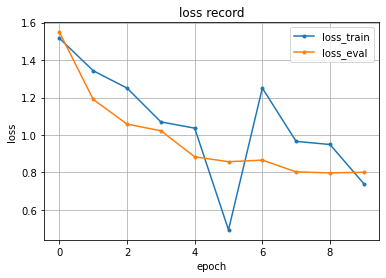

In [421]:
plot_loss(hist)

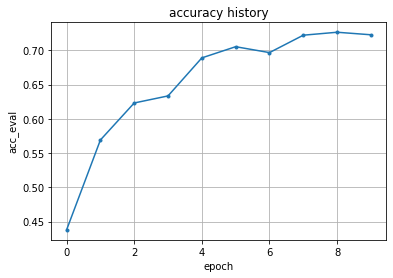

In [422]:
plot_accuracy(hist)

In [423]:
best_param = mindspore.load_checkpoint(os.path.join(ckpt_path, 'best_param.ckpt'), net=network2)
res = model.eval(test_data, dataset_sink_mode=dataset_sink_mode)
print(res)

{'accuracy': 0.7263, 'loss': 0.797391764074564}


# Effect Display

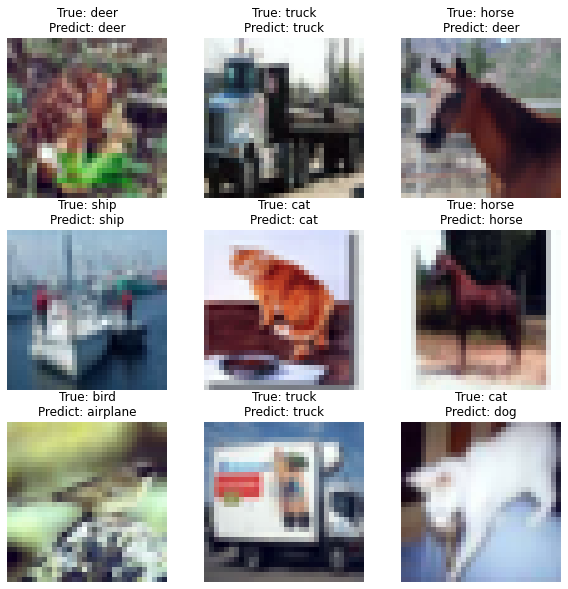

In [424]:
category_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
                 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

data_path = os.path.join('data', '10-verify-bin')
demo_data = create_dataset(test_path, batch_size=1, usage='test')


def normalize(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range


plt.figure(figsize=(10, 10))

i = 1

for dic in demo_data.create_dict_iterator():
    input_img = dic['image']
    output = model.predict(input_img)
    predict = np.argmax(output.asnumpy(), axis=1)[0]

    plt.subplot(3, 3, i)

    input_image = np.squeeze(input_img.asnumpy(), axis=0)
    input_image = input_image.transpose(1, 2, 0)
    input_image = normalize(input_image)

    plt.imshow(input_image)
    plt.axis('off')
    plt.title('True: %s\nPredict: %s' % (category_dict[dic['label'].asnumpy().item()], category_dict[predict]))

    i += 1
    if i > 9:
        break

plt.show()

# Quiz

In [432]:
"""
Questions:

1. Why should the if usage =='train' judgment formula be added before data
argumentation?
2. What are the data augmentation methods? Give examples.
3. What is a step?
4. What base class should I inherit when writing a user-defined callback function?
5. How can I obtain important information (loss function, optimizer, and current epoch
number) during the training process in the user-defined callback function?
6. If a model in this experiment is underfitting, you can optimize the model by increasing
the network complexity. If a model is overfitting, which method can be used to solve the
problem?
7. What is the dataset sink mode?
8. Why does the model's loss value in this experiment fluctuate greatly in the training set
and is higher than that in the test set?
"""

"\n1. Why should the if usage =='train' judgment formula be added before data\nargumentation?\n2. What are the data augmentation methods? Give examples.\n3. What is a step?\n4. What base class should I inherit when writing a user-defined callback function?\n5. How can I obtain important information (loss function, optimizer, and current epoch\nnumber) during the training process in the user-defined callback function?\n6. If a model in this experiment is underfitting, you can optimize the model by increasing\nthe network complexity. If a model is overfitting, which method can be used to solve the\nproblem?\n7. What is the dataset sink mode?\n8. Why does the model's loss value in this experiment fluctuate greatly in the training set\nand is higher than that in the test set?\n"

In [434]:
"""
Answers:

1. Because data augmentation (in this case, cropping and flipping) should only be used on train datasets
2. Data augmentation is used to increase the size of an existing dataset. a) Image rotation; b) blurring; c) rescaling; d) zooming; e) grayscaling; f) random noise; and g) random partial erasing.
3. If it is about saving checkpoint steps, then it means that every x (pre-defined) number of steps records will be saved as a checkpoint.
4. Callback?
5. Passing it into Model and saving epoches in TrainHistory
6. a) Increasing the number of data records (if possible, else data augmentation) b) If the model is complex, use regularization/dropouts. c) To avoid long waiting, an early stopping could be implemented if the overfit (difference between train and validation/test data sets) exceeds a predefined threshold. d) If all of the above fails, try another model or model ensemble (combine separate models predictions).
7. Determines whether the data should be passed through the dataset channel. In this case, either Ascend or GPU (Because I forgot to enable the NVidia GPU drivers, it trained on the CPU, resulting in errors and waited longer.)
8. I'm not entirely certain. Perhaps the training dataset is too small, or there is a need to increase the number of batches/each batch size (add more data records). In any case, more data would improve accuracy (data-centric approach instead of algorithm improvement). Or, as mentioned in lab guide: "The LeNet is not complex enough to produce fitting effect for the CIFAR-10 image
classification task"
"""

"\nAnswers:\n\n1. Because data augmentation (crop and flip in this case) should be applied only for train dataset\n2. Data augmentation applied for existing dataset in order to increase it's amount. a) Image rotation b) blurring c) rescaling d) zooming e) grayscaling f) random noise g) random partial erasing\n3. If it is about save checkpoint step (I guess so), then it means every x (pre-defined) number of steps record would be saved as checkpoint\n\n"